In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

read_file = pd.read_excel('/content/drive/MyDrive/Online Retail.xlsx')
read_file.to_csv('/content/drive/MyDrive/Online Retail.csv', index = None, header =True)
df = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Online Retail.csv"))
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [5]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=6ee0e532777ed43926103e95e24f3f46f561d177b55d828c09116c0d7995ac86
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Để bắt đầu các thao tác dữ liệu với PySpark, chúng ta cần khởi tạo session với SparkSession. Nó xây dựng một khung dữ liệu trong PysPark để chúng ta có thể sử dụng các chức năng của PysPark lên dữ liệu của mình

In [6]:
import pyspark
from pyspark.sql import SparkSession
# Init SparkSession
spark = SparkSession.builder.appName("Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()


In [7]:
df= spark.read.csv("/content/drive/MyDrive/Online Retail.csv", header = True, escape = "\"")
df.show(10)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|
|   536365|    21730|GLASS S

In [8]:
# Đếm xem có bao nhiêu dòng dữ liệu
df.count()


541909

In [9]:

# Có bao nhiêu khách hàng
df.select('CustomerID').distinct().count()


4373

In [10]:
from pyspark.sql.functions import *
# Định dạng lại trường dữ liệu ngày tháng thành timestamp để có thể sort, tìm min hoặc max
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy-MM-dd HH:mm:ss'))


In [11]:
# Ngày có đơn hàng gần đây nhất
df.select(max("date")).show()
# Ngày đầu tiên có đơn hàng
df.select(min("date")).show()


+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



# **Recency**
Trong phần này, mình sẽ có mục tiêu tính toán ra một giá trị đại diện cho việc thời điểm khách hàng mua lần cuối so với 1 mốc 0 nhất định (ở đây mình chọn mốc 0 là thời gian đầu tiên có đơn hàng đã tính ra bên trên). Sau đó chỉ cần lấy thời gian gần nhất khách hàng đặt đơn trừ đi mốc thời gian đó, ta sẽ có 1 giá trị đại diện cho Recency. Rõ ràng giá trị này càng lớn chứng tỏ khách hàng càng mua gần đây. Việc tính toán này sẽ thông qua 1 số bước như sau

In [12]:
df = df.withColumn("from_date", lit("2010-12-01 08:26:00"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy-MM-dd HH:mm'))
df2 = df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')
df.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|               date|          from_date|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|2010-

# **Frequency**
Phần này thì chúng ta sẽ tính tần suất một khách hàng mua một đồ gì đó. Chúng ta chỉ cần nhóm theo từng ID khách hàng và đếm số mặt hàng họ đã mua

In [13]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceNo').alias('frequency'))
df_freq.show()

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|   17786.0|       72|
|   16917.0|        9|
|   15891.0|       62|
|   17955.0|        1|
|   14542.0|        5|
|   12891.0|        1|
|   16553.0|        1|
|   14532.0|       20|
|   17536.0|        3|
|   14722.0|       29|
|   13827.0|       65|
|   17353.0|        4|
|   15070.0|        1|
|   16351.0|        8|
|   18085.0|       20|
|   12350.0|       17|
|   14727.0|       10|
|   16838.0|       11|
|   13533.0|       33|
|   15016.0|       20|
+----------+---------+
only showing top 20 rows



In [14]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')
df3.show()

+----------+-------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID|recency|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|       Country|               date|          from_date|frequency|
+----------+-------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|   18074.0|   5220|   536384|    82484|WOOD BLACK BOARD ...|       3|2010-12-01 09:53:00|     6.45|United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|       13|
|   18074.0|   5220|   536384|    84755|COLOUR GLASS T-LI...|      48|2010-12-01 09:53:00|     0.65|United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|       13|
|   18074.0|   5220|   536384|    22464|HANGING METAL HEA...|      12|2010-12-01 09:53:00|     1.65|United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|       13|
|   

# Monetary
Phần này tính xem mỗi khách hàng đã chi bao nhiêu tiền để mua sắm

In [15]:
#Tính số lượng và đơn giá của một lần mua hàng
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

#Tính tổng số tiền mà khách hàng đã chi
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))
m_val.show()

+----------+------------------+
|CustomerID|    monetary_value|
+----------+------------------+
|   17786.0|            278.74|
|   16917.0| 391.5200000000001|
|   15891.0|            524.52|
|   17955.0|             163.2|
|   14542.0|103.25000000000001|
|   12891.0|              85.0|
|   16553.0|             204.0|
|   14532.0|            140.55|
|   17536.0|              76.5|
|   14722.0|187.91999999999996|
|   13827.0|            299.31|
|   17353.0|             870.0|
|   15070.0|             106.2|
|   16351.0|             153.9|
|   18085.0|386.04999999999995|
|   12350.0|334.40000000000003|
|   14727.0|            268.58|
|   16838.0|196.73000000000002|
|   13533.0|124.14999999999999|
|   15016.0|            170.04|
+----------+------------------+
only showing top 20 rows



In [16]:
final_df = m_val.join(df3,on='CustomerID',how='inner')
final_df.show()

+----------+--------------+-------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID|monetary_value|recency|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|       Country|               date|          from_date|frequency|
+----------+--------------+-------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|   17786.0|        278.74|4860540|   542239|    21166|COOK WITH WINE ME...|       3|2011-01-26 14:35:00|     1.95|United Kingdom|2011-01-26 14:35:00|2010-12-01 08:26:00|       72|
|   17786.0|        278.74|4860540|   542239|    21181|PLEASE ONE PERSON...|       2|2011-01-26 14:35:00|      2.1|United Kingdom|2011-01-26 14:35:00|2010-12-01 08:26:00|       72|
|   17786.0|        278.74|4860540|   542239|    85150|LADIES & GENTLEME...|       1|2011-01-26

In [17]:
#final data with 4 truong du lieu
final_df = final_df.select(['recency','frequency','monetary_value','CustomerID']).distinct()
final_df.show()

+--------+---------+------------------+----------+
| recency|frequency|    monetary_value|CustomerID|
+--------+---------+------------------+----------+
| 4860540|       72|            278.74|   17786.0|
| 8393340|        9| 391.5200000000001|   16917.0|
|12715740|       62|            524.52|   15891.0|
|15132840|        1|             163.2|   17955.0|
|16242780|        5|103.25000000000001|   14542.0|
|16257900|        1|              85.0|   12891.0|
|18170160|        1|             204.0|   16553.0|
|11853540|       20|            140.55|   14532.0|
|16952220|        3|              76.5|   17536.0|
|19549920|       29|187.91999999999996|   14722.0|
|20747940|       65|            299.31|   13827.0|
|21113580|        4|             870.0|   17353.0|
|   97020|        1|             106.2|   15070.0|
| 3549600|        8|             153.9|   16351.0|
| 3739860|       20|386.04999999999995|   18085.0|
| 5470500|       17|334.40000000000003|   12350.0|
| 8576340|       10|           

# Chuẩn hóa dữ liệu voi pyspark.ml

In [18]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(final_df)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.select("standardized").show(2, truncate = False)

+-----------------------------------------------------------+
|standardized                                               |
+-----------------------------------------------------------+
|[0.5572788241232707,1.8590204479466206,0.09971413970075937]|
|[0.9623273639691913,0.23237755599332757,0.1400591231098562]|
+-----------------------------------------------------------+
only showing top 2 rows



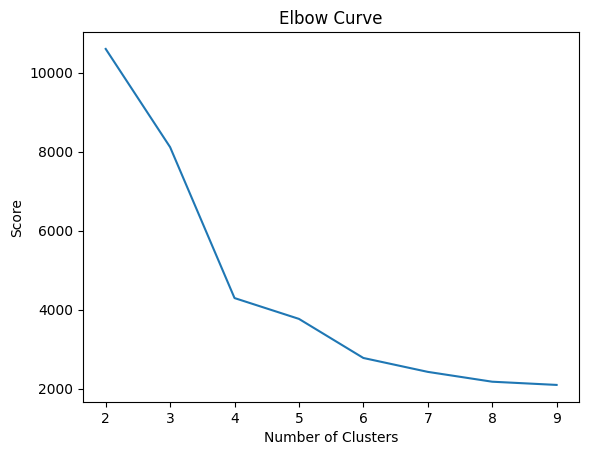

In [19]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()


+--------+---------+------------------+----------+--------------------+--------------------+----------+
| recency|frequency|    monetary_value|CustomerID|            features|        standardized|prediction|
+--------+---------+------------------+----------+--------------------+--------------------+----------+
| 4860540|       72|            278.74|   17786.0|[4860540.0,72.0,2...|[0.55727882412327...|         0|
| 8393340|        9| 391.5200000000001|   16917.0|[8393340.0,9.0,39...|[0.96232736396919...|         0|
|12715740|       62|            524.52|   15891.0|[1.271574E7,62.0,...|[1.45790645382143...|         0|
|15132840|        1|             163.2|   17955.0|[1.513284E7,1.0,1...|[1.73503587684611...|         0|
|16242780|        5|103.25000000000001|   14542.0|[1.624278E7,5.0,1...|[1.86229458843934...|         0|
+--------+---------+------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



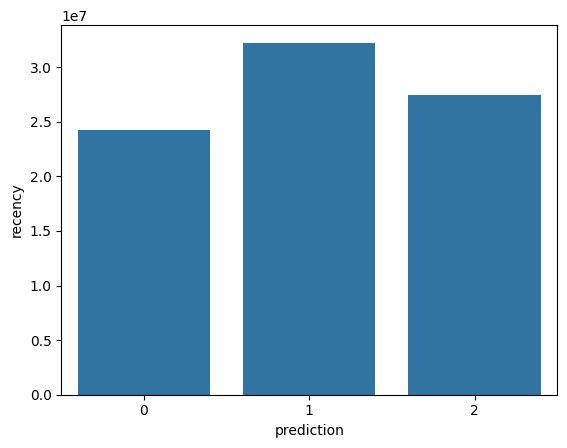

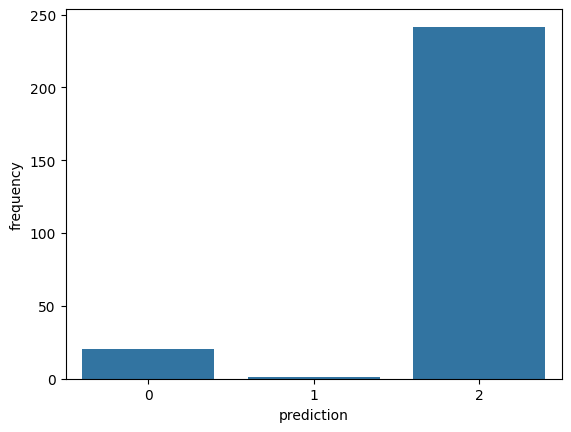

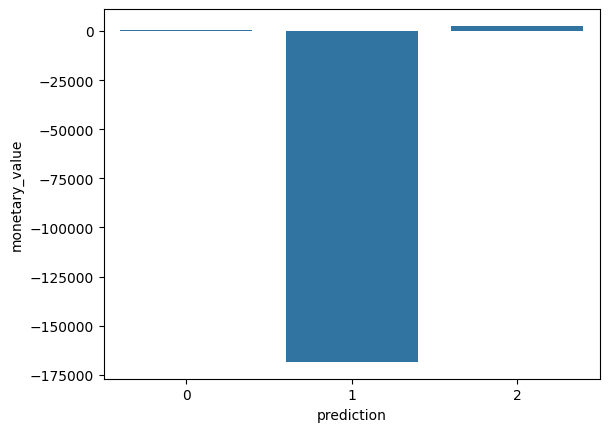

In [20]:
kmeans_algo=KMeans(featuresCol='standardized', k=3)
kmeans_fit=kmeans_algo.fit(data_scale_output)
preds=kmeans_fit.transform(data_scale_output)
preds.show(5)
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()


Hình vẽ tương đối rõ ràng về các đặc trưng, chúng ta có thể rút ra được một số nhận xét tổng quan như sau:





*   Nhóm 0: Nhóm này có tần suất mua hàng tương đối cao, cao trội hơn 3 nhóm còn lại, lần truy cập gần nhất cũng tương đối cao, giá trị tiền mua hàng tương đối nhỏ, cho thấy là một đối tượng đa số là cá nhân, hướng tới các sản phẩm giá rẻ
*   Nhóm 1: Nhóm này có cả 3 chỉ số lần truy cập gần nhất, tấn suất mua hàng và tổng tiền mua hàng rất thấp, không có quá nhiều hi vọng là khách hàng tiềm năng, khả năng cao sẽ ngừng mua hàng trong thời gian tới

*   Nhóm 2: Tần suất đặt hàng rất ít, tuy nhiên gần đây lại đặt phổ biến, lượng tiền mua hàng cao vượt trội nhiều lần so với các nhóm khác. Nhóm này khả năng là các doanh nghiệp có xu hướng mua các loại hàng có giá trị cao hoặc mua có số lượng lớn
*   
Nhóm 3: Nhóm này có tổng tiền mua hàng rất thấp, tần suất mua hàng không quá nhiều, và truy cập gần đây tương đối cao. Nhóm này có khả năng mua theo đợt, hoặc là những người mới tham gia sàn thương mại.



